In [2]:
%load_ext autoreload
%autoreload 2

In [45]:
from scripts.drawer import russia_plots
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pickle

### Russia geom

In [27]:
gauges_file = gpd.read_file('../geo_data/geometry/russia_gauges.gpkg')
ws_file = gpd.read_file('../geo_data/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
basemap_data = gpd.read_file('../geo_data/geometry/russia_forest_25people.geojson')

In [138]:
test_gauges = pd.read_csv('./data/basins_test.txt', names=['gauge_id'])
test_gauges['gauge_id'] = test_gauges['gauge_id'].astype(str)
train_gauges = pd.read_csv('./data/basins_train.txt', names=['gauge_id'])
train_gauges['gauge_id'] = train_gauges['gauge_id'].astype(str)
val_gauges = pd.read_csv('./data/basins_val.txt', names=['gauge_id'])
val_gauges['gauge_id'] = val_gauges['gauge_id'].astype(str)

for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in test_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'test'
    elif val in train_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'train'
    elif val in val_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'val'
    else:
        gauges_file.loc[i, 'status'] = np.NaN
gauges_file

,gauge_id,name_ru,name_en,area,geometry,status
0,49001,р.Ковда - пос.Софпорог,r.Kovda - pos.Sofporog,3520.00,POINT (31.41892 65.79876),NaN
1,49014,р.Корпи-Йоки - пос.Пяозерский,r.Korpi-Joki - pos.Pjaozerskij,217.00,POINT (31.05345 65.78181),NaN
2,49017,р.Тумча - пос.Алакуртти,r.Tumcha - pos.Alakurtti,2100.00,POINT (30.33082 66.95957),NaN
3,49030,р.Кузема - ст.Кузема,r.Kuzema - st.Kuzema,882.00,POINT (34.23039 65.37582),NaN
4,49047,р.Судно - с.Вокнаволок,r.Sudno - s.Voknavolok,1160.00,POINT (30.51036 64.95441),NaN
...,...,...,...,...,...,...
2075,72477,р.Кунья - д.Уварово,r.Kun'ja - d.Uvarovo,2480.00,POINT (30.93000 56.78000),NaN
2076,72641,руч.Мельничный - д.Брод,ruch.Mel'nichnyj - d.Brod,4.24,POINT (28.40000 58.63000),NaN
2077,72680,кан.Магистральный - д.Люцково г/ств.N1,kan.Magistral'nyj - d.Ljutskovo g/stv.N1,5.21,POINT (28.51000 56.73000),NaN
2078,72751,р.Лучинка - д.Травино,r.Luchinka - d.Travino,31.00,POINT (29.36386 57.39953),NaN


<class 'geopandas.geodataframe.GeoDataFrame'>


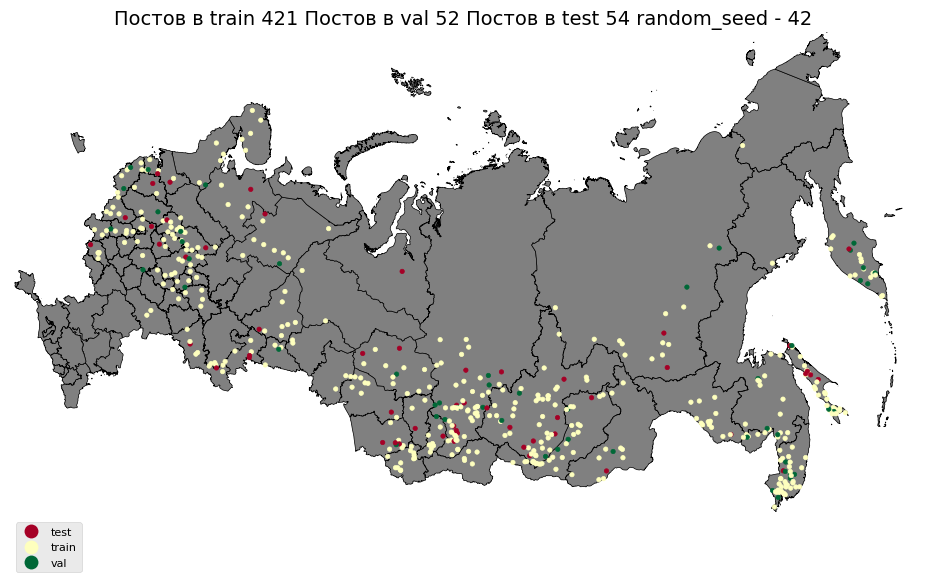

In [143]:
gauges_fig = russia_plots(gdf_to_plot=gauges_file.dropna(),
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""Постов в train {len(train_gauges)}\
 Постов в val {len(val_gauges)}\
 Постов в test {len(test_gauges)}\
 random_seed - 42""",
                          just_points=True);


In [4]:
q_obs = {'full': list(),
         'partial': list(),
         'empty': list()}
h_obs = {'full': list(),
         'partial': list(),
         'empty': list()}

def nan_fractor(df_col: pd.Series):
    nan_frac = df_col.isna().sum() / len(df_col)
    return nan_frac

for file in glob.glob('../geo_data/great_db/ais_data/q_h/*.csv'):
    gauge_id = file.split('/')[-1][:-4]
    test = pd.read_csv(file, index_col='date')
    lvls = test[['lvl_sm', 'lvl_mbs']]
    dschrg = test[['q_cms_s', 'q_mm_day']]
    
    fraction_of_nan_q = dschrg['q_cms_s'].isna().sum() / len(dschrg)
    
    if fraction_of_nan_q == 0.0:
        q_obs['full'].append(gauge_id)
    elif fraction_of_nan_q <= 0.25:
        q_obs['partial'].append(gauge_id)
    elif fraction_of_nan_q > 0.25:
        q_obs['empty'].append(gauge_id)
        
    fraction_of_nan_h = lvls['lvl_mbs'].isna().sum() / len(lvls)
    
    if fraction_of_nan_h == 0.0:
        h_obs['full'].append(gauge_id)
    elif fraction_of_nan_h <= 0.25:
        h_obs['partial'].append(gauge_id)
    elif fraction_of_nan_h > 0.25:
        h_obs['empty'].append(gauge_id)


In [5]:
[len(val) for val in h_obs.values()]

[1989, 634, 191]

In [6]:
[len(val) for val in q_obs.values()]

[1249, 517, 1048]

In [11]:
gauges_file[gauges_file['status'].isna()]

,gauge_id,name_ru,name_en,geometry,status
58,71284,р.Пиренга - регулирующее сооружение,r.Pirenga - regulirujuschee sooruzhenie,POINT (32.30078 67.55977),NaN
736,10011,вдхр.Новосибирское(р.Обь) - ГЭС Новосибирская,vdhr.Novosibirskoe(r.Ob') - GES Novosibirskaja,POINT (82.98839 54.84930),NaN
1763,84286,р.Акташ - с.Эндирей Аул,r.Aktash - s.Endirej Aul,POINT (46.65000 43.16000),NaN
1769,84333,р.Гамри-Озень - с.Бурдеки,r.Gamri-Ozen' - s.Burdeki,POINT (47.67529 42.29756),NaN
1783,84415,р.Ярык-Су - с.Ново-Кули,r.Jaryk-Su - s.Novo-Kuli,POINT (46.51000 43.16000),NaN
1957,49116,руч.Без названия - пос.Каменный бор,ruch.Bez nazvanija - pos.Kamennyj bor,POINT (34.17576 63.93409),NaN
1972,72680,кан.Магистральный - д.Люцково г/ств.N1,kan.Magistral'nyj - d.Ljutskovo g/stv.N1,POINT (28.51414 56.73911),NaN
1974,9593,руч.Разведочный - 0.05 км от устья,ruch.Razvedochnyj - 0.05 km ot ust'ja,POINT (88.18357 69.32947),NaN
1978,75438,р.Закза - д.Большое Сареево,r.Zakza - d.Bol'shoe Sareevo,POINT (37.18917 55.71026),NaN
1979,75435,р.Медвенка - д.Большое Сареево,r.Medvenka - d.Bol'shoe Sareevo,POINT (37.18360 55.71381),NaN


### Plots for discharges

<class 'geopandas.geodataframe.GeoDataFrame'>


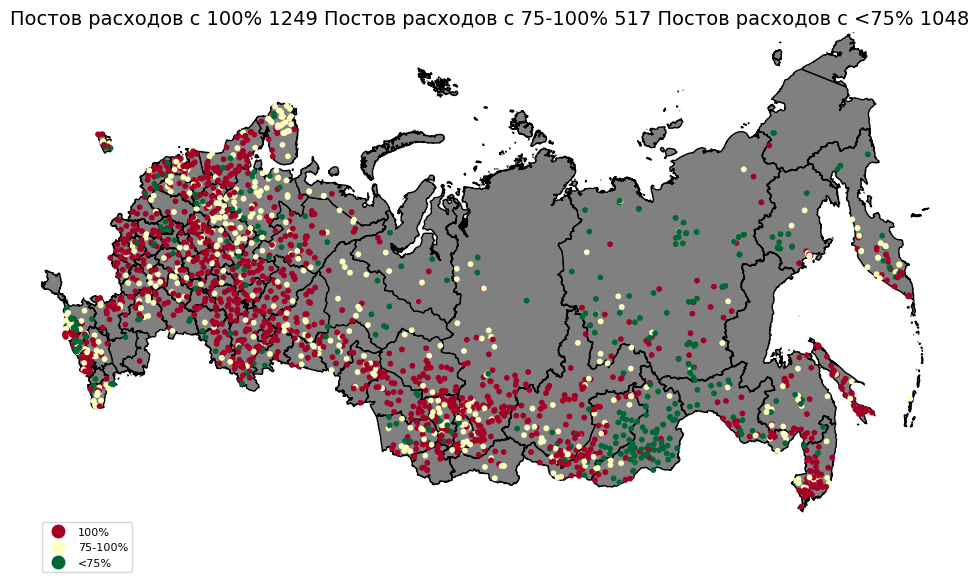

In [9]:
gauges_file = gpd.read_file('../geo_data/geometry/russia_gauges.gpkg')
for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in q_obs['full']:
        gauges_file.loc[i, 'status'] = '100%'
    elif val in q_obs['partial']:
        gauges_file.loc[i, 'status'] = '75-100%'
    elif val in q_obs['empty']:
        gauges_file.loc[i, 'status'] = '<75%'

gauges_fig = russia_plots(gdf_to_plot=gauges_file,
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""Постов расходов с 100% {len(q_obs['full'])}\
 Постов расходов с 75-100% {len(q_obs['partial'])}\
 Постов расходов с <75% {len(q_obs['empty'])}""",
                          just_points=True);

### Levels

<class 'geopandas.geodataframe.GeoDataFrame'>


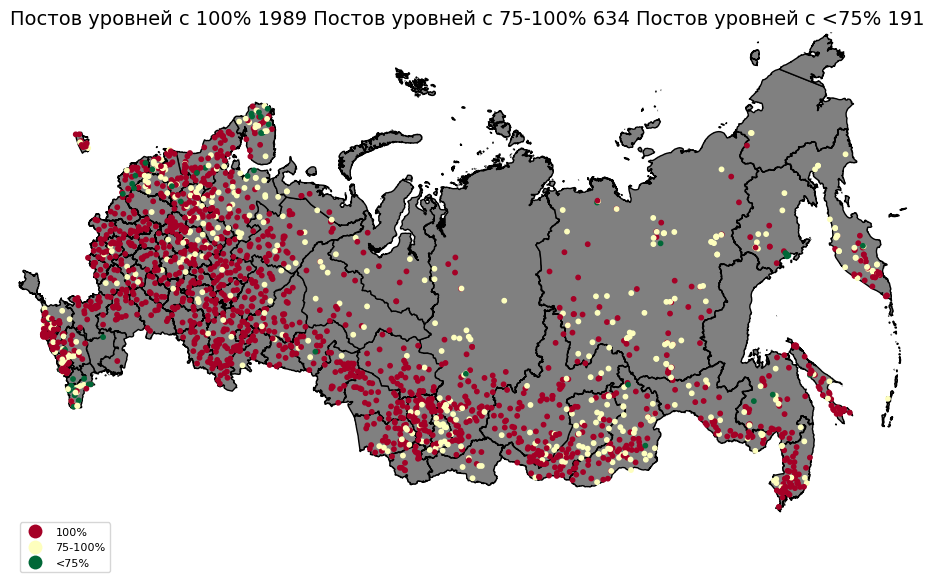

In [12]:
gauges_file = gpd.read_file('../geo_data/geometry/russia_gauges.gpkg')

for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in h_obs['full']:
        gauges_file.loc[i, 'status'] = '100%'
    elif val in h_obs['partial']:
        gauges_file.loc[i, 'status'] = '75-100%'
    elif val in h_obs['empty']:
        gauges_file.loc[i, 'status'] = '<75%'

gauges_fig = russia_plots(gdf_to_plot=gauges_file,
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""Постов уровней с 100% {len(h_obs['full'])}\
 Постов уровней с 75-100% {len(h_obs['partial'])}\
 Постов уровней с <75% {len(h_obs['empty'])}""",
                          just_points=True);


### Check model quality

In [5]:
def metric_viewer(metric_csv: 'str'):
    model_metric = pd.read_csv(metric_csv)
    model_metric = model_metric.rename(columns={'basin': 'gauge_id'})
    model_metric['gauge_id'] = model_metric['gauge_id'].astype('str')
    model_metric = model_metric.set_index('gauge_id')

    res_file = gauges_file.set_index('gauge_id').join(model_metric).dropna()
    nse_median = res_file['NSE'].median()
    res_file.loc[res_file['NSE'] < 0, 'NSE'] = 0
    
    return res_file, nse_median
    

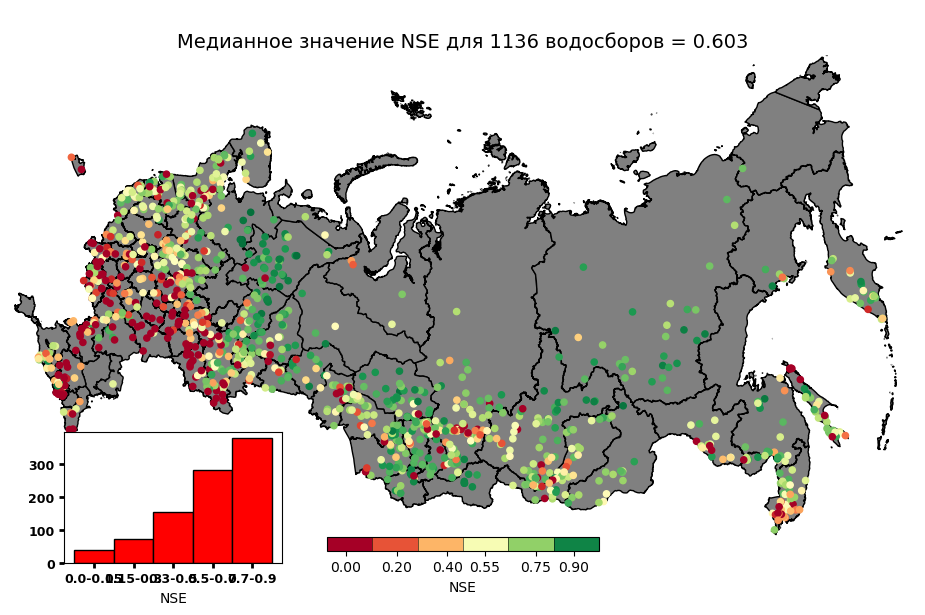

In [6]:
era5_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/era5_prcp_2803_054055/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_file)} водосборов = {nse_median:.3f}""");

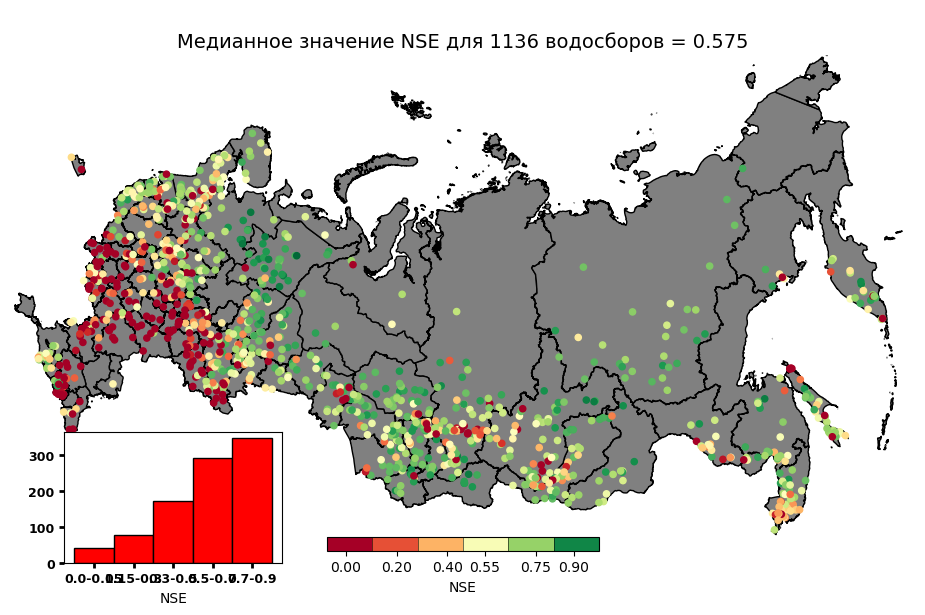

In [16]:
era5_land_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/era5_land_prcp_2803_125025/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=era5_land_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_land_file)} водосборов = {nse_median:.3f}""");

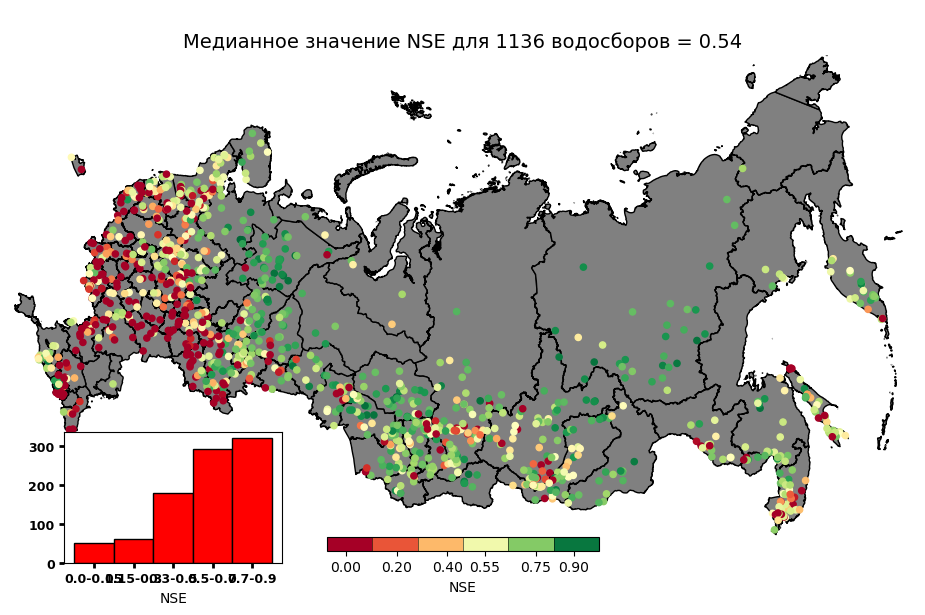

In [17]:
gpcp_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/gpcp_prcp_3003_063422/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=gpcp_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(gpcp_file)} водосборов = {nse_median:.2f}""");

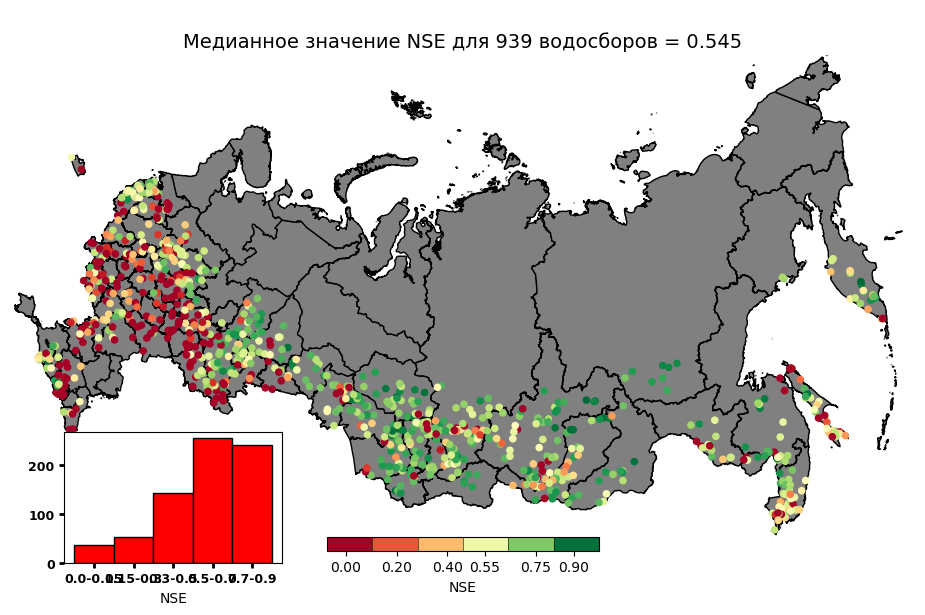

In [20]:
imerg_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/imerg_prcp_3003_135405/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=imerg_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(imerg_file)} водосборов = {nse_median:.3f}""");

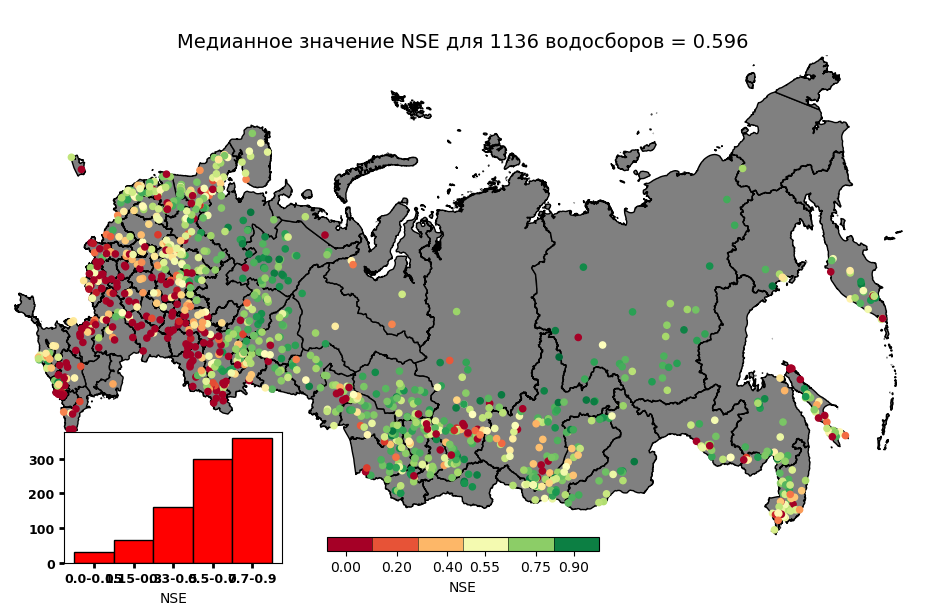

In [21]:
mswep_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/mswep_prcp_3103_073833/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=mswep_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(mswep_file)} водосборов = {nse_median:.3f}""");

### View BAD results

In [7]:
with open('../test_meteo_input/runs_q_cms/era5_prcp_2803_054055/test/model_epoch042/test_results.p',
          "rb") as fp:
    results = pickle.load(fp)

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


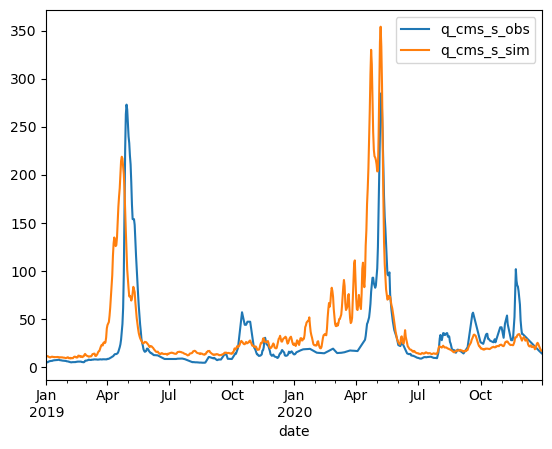

In [22]:
fig = results['49090']['1D']['xr'].drop('time_step').to_dataframe().droplevel(level=1).plot().get_figure();

fig.savefig('test.jpg')

In [ ]:
poor_gauges = era5_file[era5_file['NSE'] < 0.4]
for gauge in poor_gauges.index:
    
    nse = poor_gauges.loc[gauge, 'NSE']
    area = ws_file.loc[gauge, 'new_area']
    xr.open_dataset(f'../geo_data/great_db/nc_all_q/{gauge}.nc').drop('gauge_id').to_dataframe()[['lvl_sm', 'q_cms_s', 'q_mm_day', 'prcp_e5', 'prcp_e5l', 'prcp_mswep', 'prcp_gpcp']].to_csv(f'./recovery/{gauge}.csv')
    fig = results[gauge]['1D']['xr'].drop(
        'time_step').to_dataframe().droplevel(level=1).plot(
            figsize=(15, 10),
            fontsize=18).get_figure();
    plt.title(f'{nse} for catchment {gauge} with area of {area:.3f}',
              fontsize=20)
    fig.tight_layout()
    fig.savefig(f"./images/{gauge}.png")
    # plt.show()

### Outlier remover

In [51]:
example_file = pd.read_csv('./recovery/10058.csv',
                           index_col='date')
example_file.index = pd.to_datetime(example_file.index)
example_file

,lvl_sm,q_cms_s,q_mm_day,prcp_e5,prcp_e5l,prcp_mswep,prcp_gpcp
date,,,,,,,
2008-01-01,25.0,17.00,100.177329,0.001252,0.004483,0.000000,0.000000
2008-01-02,24.0,16.00,94.284545,0.000000,0.003494,0.000000,0.000000
2008-01-03,17.0,16.00,94.284545,2.190799,1.011411,0.126885,0.567415
2008-01-04,16.0,16.00,94.284545,1.057222,1.675332,0.126885,0.000000
2008-01-05,16.0,16.00,94.284545,0.465194,0.252440,0.348934,1.233340
...,...,...,...,...,...,...,...
2020-12-27,34.0,0.15,0.883918,0.006840,0.027936,0.000000,0.000000
2020-12-28,34.0,0.15,0.883918,0.000000,0.001886,0.031721,0.000000
2020-12-29,34.0,0.15,0.883918,0.000000,0.002033,0.000000,0.000000


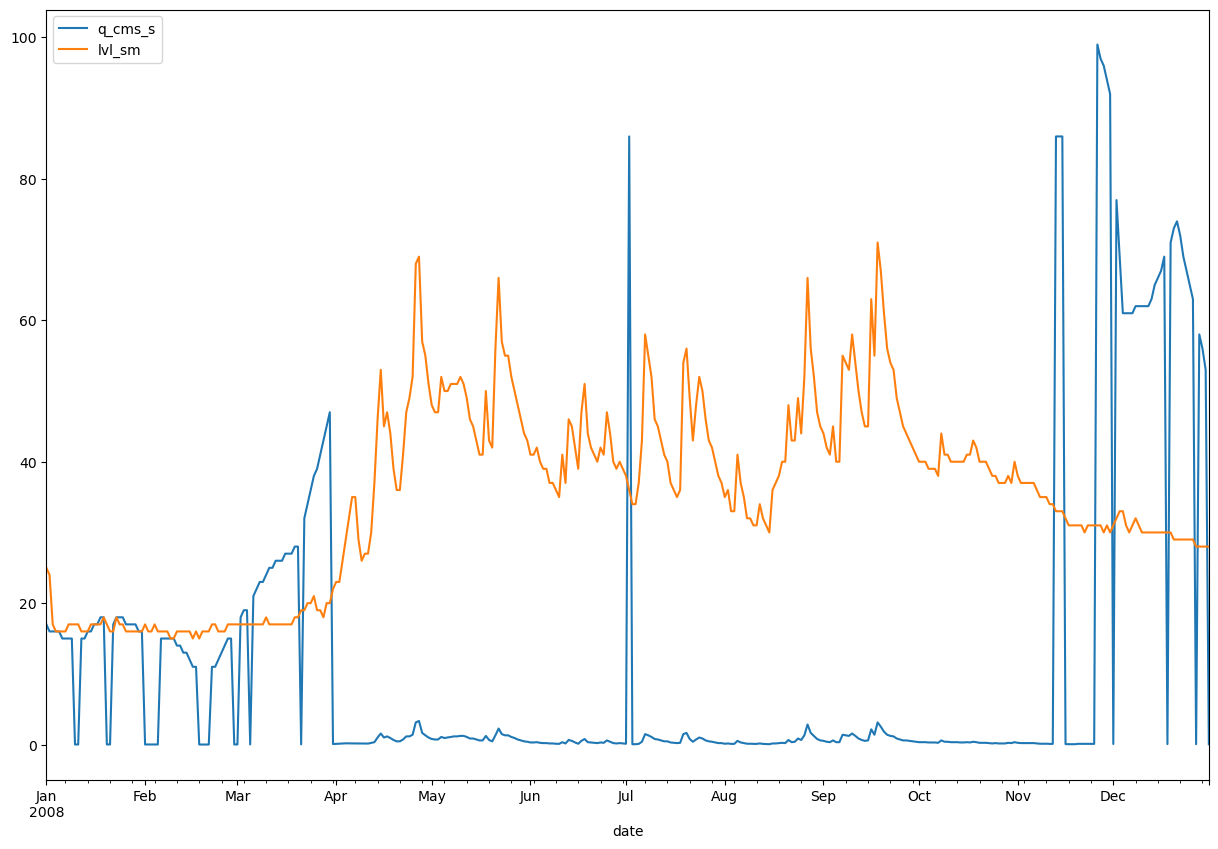

In [64]:
example_file.loc['2008', ['q_cms_s', 'lvl_sm']].plot(figsize=(15, 10));

In [11]:
def create_gdf_for_plot(df: pd.DataFrame,
                        geom_df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """[summary]

    Args:
        df ([type]): [description]
        geom_df ([type]): [description]

    Returns:
        [type]: [description]
    """
    pd.options.mode.chained_assignment = None
    df['geometry'] = geom_df['centroids']
    df = gpd.GeoDataFrame(df)

    return df

### Meteo plots

In [6]:
from pathlib import Path
path_to_store = Path('./meteo_visualisations/')
path_to_store.mkdir(exist_ok=True, parents=True)
from typing import Tuple

def read_maurer(maurer_path: Path, basin: str) -> Tuple[pd.DataFrame, float]:
    """[summary]

    Args:
        basin (str): [description]

    Raises:
        RuntimeError: [description]

    Returns:
        Tuple[pd.DataFrame, float]: [description]
    """

    files = list(maurer_path.glob('**/*_forcing_leap.txt'))
    file_path = [f for f in files if f.name[:8] == basin]
    if len(file_path) == 0:
        raise RuntimeError(f'No file for Basin {basin} at {file_path}')
    else:
        file_path = file_path[0]

    df = pd.read_csv(file_path, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str))
    df['date'] = pd.to_datetime(dates, format="%Y-%m-%d")
    df = df.set_index('date', drop=True)

    # load area from header
    with open(file_path, 'r') as fp:
        content = fp.readlines()
        area = round(float(content[2]), 2)
        area /= 10**6

    return df, area


In [7]:
gauges = list(area_data.index)

In [8]:
differ_files = dict()

for gauge in tqdm(gauges):
    # read meteo file
    area = area_data.loc[gauge, 'ws_area']
    meteo_maurer, _ = read_maurer(maurer_path=Path(
        './data/CAMELS/basin_mean_forcing/maurer_extended'
    ),
        basin=gauge)
    meteo_era = pd.read_csv(f'./data/CAMELS/forcings/{gauge}.csv')
    meteo_era['date'] = pd.to_datetime(meteo_era['date'])
    meteo_era = meteo_era.set_index('date', drop=True)

    res_file = meteo_era.join(meteo_maurer)
    res_file = res_file['01/01/1980':'12/31/2008']
    res_file = res_file.rename(columns={'prcp(mm/day)': 'prcp',
                                        'srad(W/m2)': 'srad',
                                        'swe(mm)': 'swe',
                                        'tmax(C)': 'tmax',
                                        'tmin(C)': 'tmin',
                                        'vp(Pa)': 'vp'})

    differ_files[gauge] = res_file[['temp_max', 'tmax', 'temp_min',
                                    'tmin', 'precip', 'prcp']]


def get_mae_prcp(gauge):
    precip, prcp = differ_files[gauge][['precip', 'prcp']].groupby(
        pd.Grouper(freq='1Y')).sum().mean().values

    res = prcp - precip
    area = area_data.loc[gauge, 'ws_area']

    return (precip, prcp, area)


fin_res = pd.DataFrame()
for gauge, val in differ_files.items():

    era, maurer, area = get_mae_prcp(gauge)
    fin_res.loc[gauge, 'area'] = area
    fin_res.loc[gauge, 'prcp_Era'] = era
    fin_res.loc[gauge, 'prcp_Maurer'] = maurer

fin_res['area_gradation'] = pd.cut(fin_res['area'],
                                   bins=[0, 250, 500, 1000, 2000, np.inf],
                                   right=False,
                                   include_lowest=False)
# group_fin = fin_res.groupby('area_gradation').mean()
era_df = pd.DataFrame()
era_df = fin_res[['area', 'prcp_Era']]
era_df = era_df.rename(columns={'prcp_Era': 'prcp'})
era_df.loc[:, 'tag'] = 'ERA5'

maurer_df = pd.DataFrame()
maurer_df = fin_res[['area', 'prcp_Maurer']]
maurer_df.loc[:, 'tag'] = 'Maurer'
maurer_df = maurer_df.rename(columns={'prcp_Maurer': 'prcp'})

maurer_vs_era = pd.concat([era_df, maurer_df]).reset_index(drop=True)


A Jupyter Widget

/tmp/ipykernel_1198/88103196.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maurer_df.loc[:, 'tag'] = 'Maurer'


In [9]:
fin_res


,area,prcp_Era,prcp_Maurer,area_gradation
01013500,2302.903431,1131.943053,986.478621,"[2000.0, inf)"
01022500,620.423845,1146.762302,1207.854828,"[500.0, 1000.0)"
01030500,3675.502151,1128.475597,1085.230345,"[2000.0, inf)"
01031500,766.509220,1176.784675,1161.034483,"[500.0, 1000.0)"
01047000,904.969099,1178.680671,1152.266207,"[500.0, 1000.0)"
...,...,...,...,...
14309500,226.431942,1329.677149,1843.521724,"[0.0, 250.0)"
14316700,588.244890,1582.616854,1603.937931,"[500.0, 1000.0)"
14325000,445.160763,1489.699641,2585.008276,"[250.0, 500.0)"
14362250,43.907511,1022.074773,945.884828,"[0.0, 250.0)"


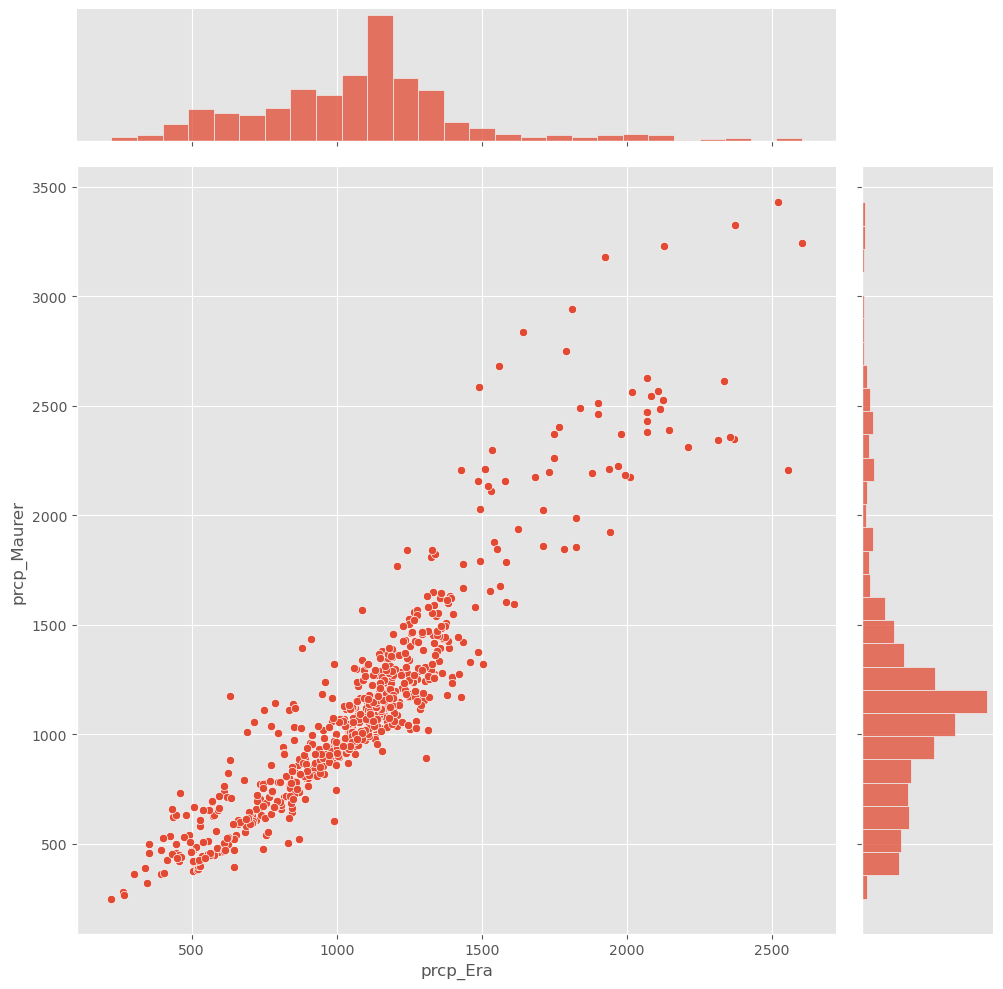

In [8]:
import seaborn as sns
sns.jointplot(data=fin_res, x="prcp_Era", y="prcp_Maurer", height=10);


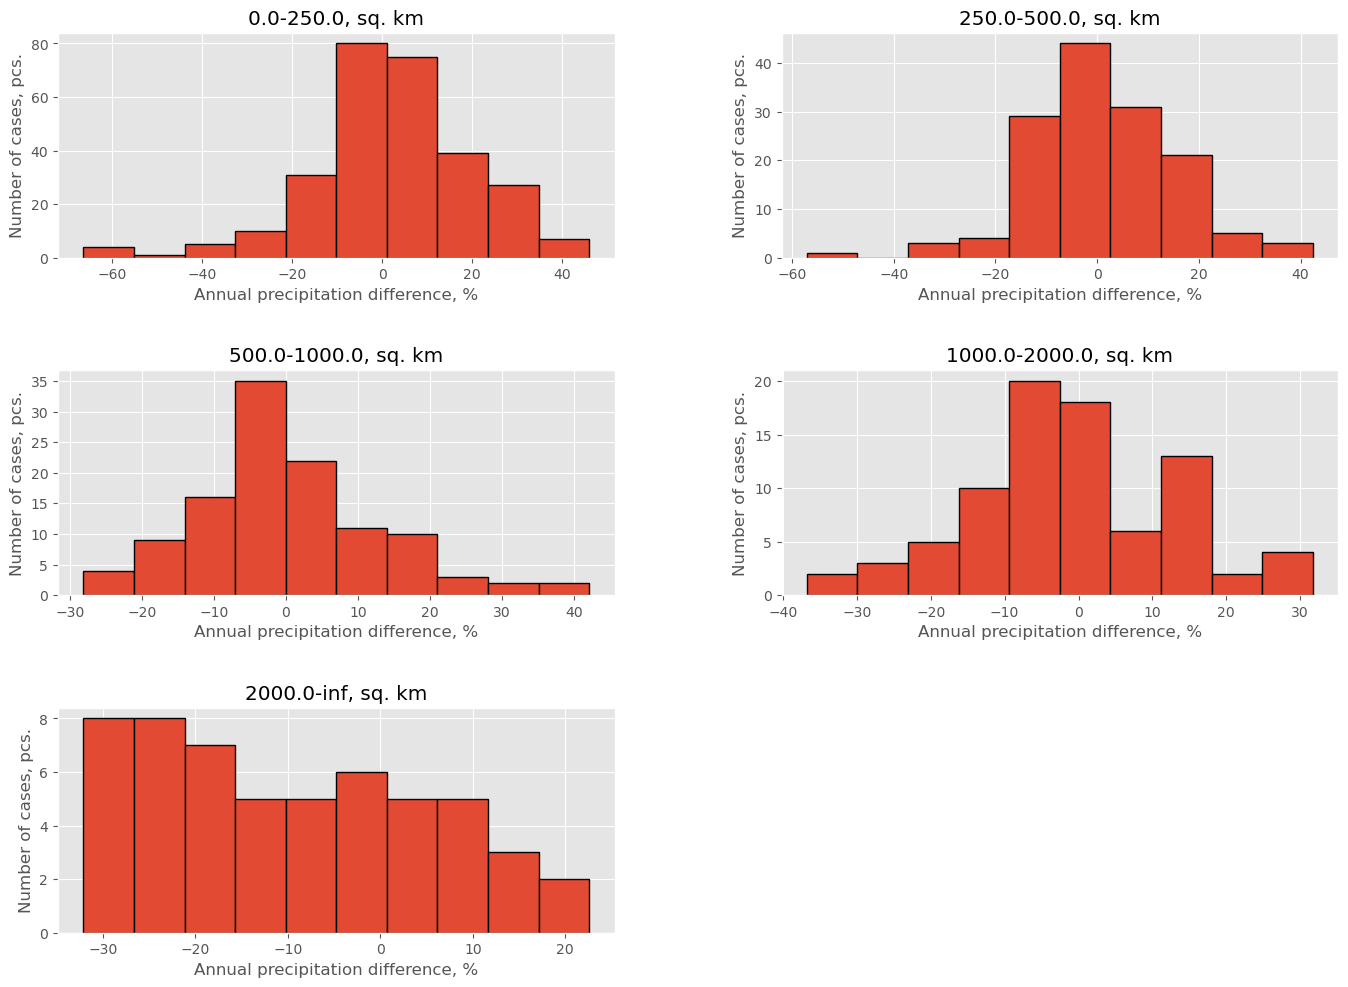

In [11]:
my_hist = fin_res.hist(column='prcp_diff',
                       by='area_gradation',
                       figsize=(16, 12),
                       edgecolor='black', linewidth=1)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in np.unique(fin_res['area_gradation'])]
xlbl = [f'{lbl}, sq. km' for lbl in xlbl]

for i, ax in enumerate(my_hist.flatten()[:-1]):
    ax.set_title(xlbl[i])
    ax.set_xlabel("Annual precipitation difference, %")
    ax.set_ylabel('Number of cases, pcs.')
    ax.tick_params(axis='x', labelrotation=0);


In [11]:
from sklearn.metrics import r2_score


def get_r2(precip_df, frequency: str):
    precip_df = precip_df.groupby(pd.Grouper(freq=frequency)).sum()
    return r2_score(y_true=precip_df['prcp'],
                    y_pred=precip_df['precip'])


def value_hist(column_to_plot: str,
               frequency: str,
               xlabel: str):

    fin_res[column_to_plot] = [get_r2(data,
                                  frequency=frequency)
                           for data in differ_files.values()]

    my_hist = fin_res.hist(column=column_to_plot,
                           by='area_gradation',
                           figsize=(16, 12),
                           edgecolor='black', linewidth=1)

    xlbl = [str(col)[1:-1].replace(', ', '-')
            for col in np.unique(fin_res['area_gradation'])]
    xlbl = [f'{lbl}, кв. км' for lbl in xlbl]

    for i, ax in enumerate(my_hist.flatten()[:-1]):
        ax.set_title(xlbl[i])
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Число объектов, шт.')
        ax.tick_params(axis='x', labelrotation=0)


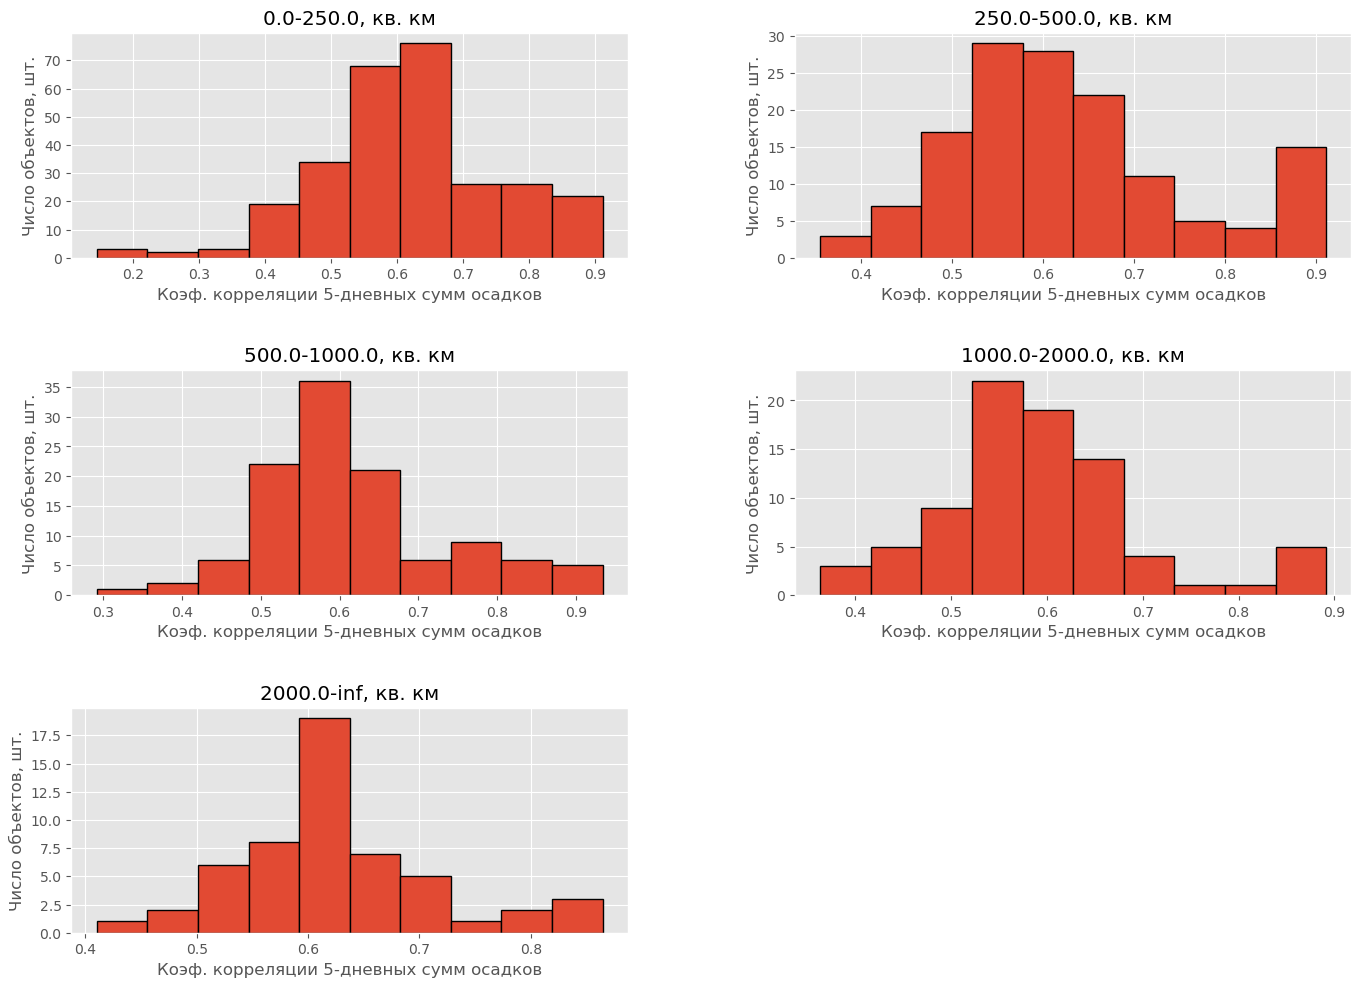

In [12]:
value_hist(column_to_plot='r2_5d',
           frequency='5d',
           xlabel="Коэф. корреляции 5-дневных сумм осадков")

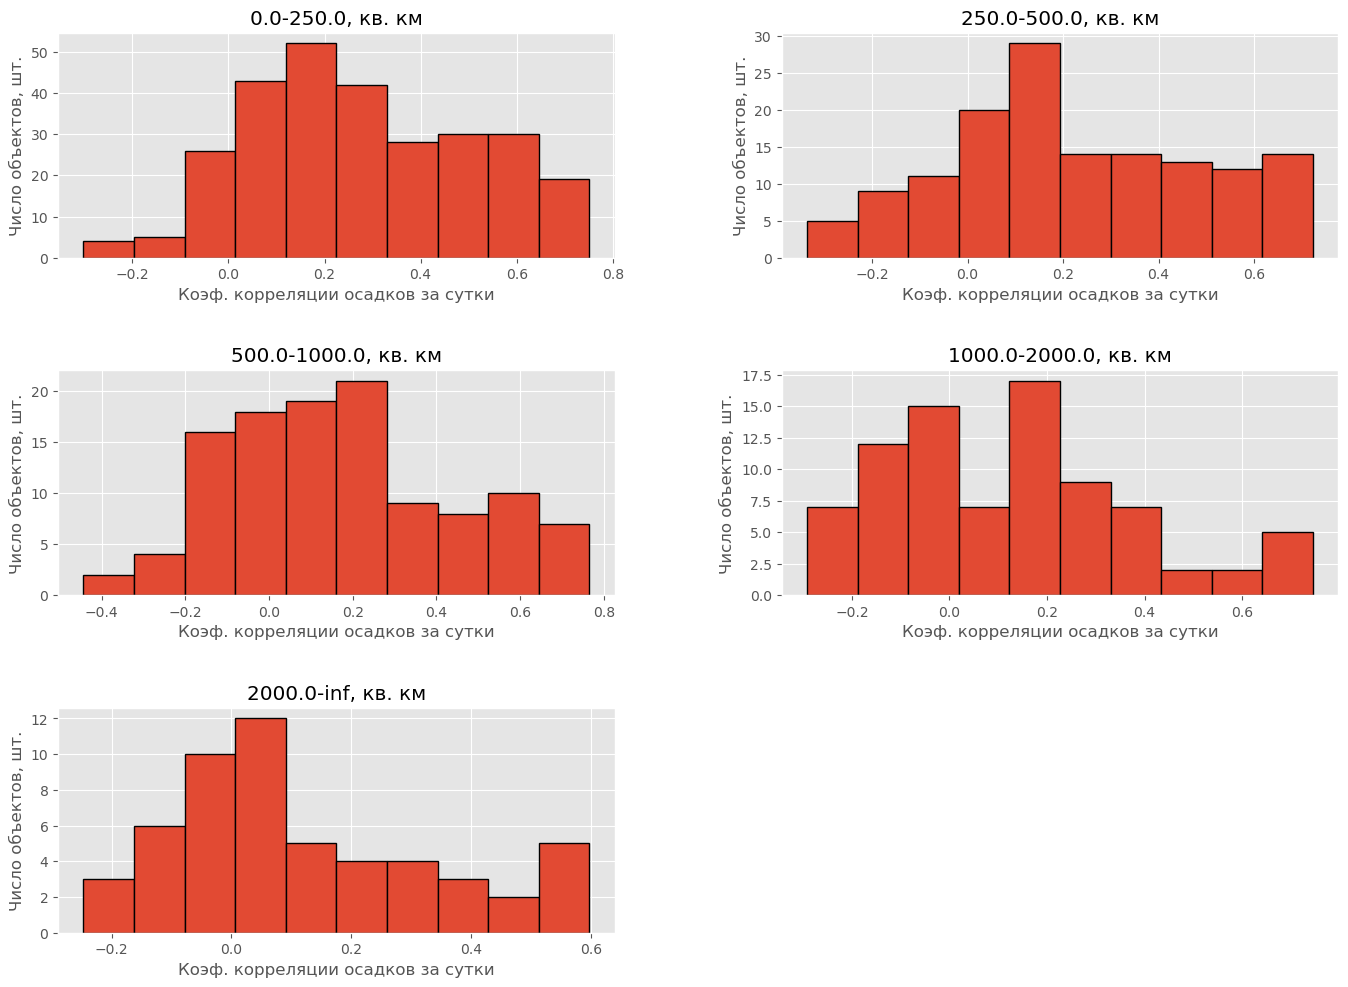

In [13]:
value_hist(column_to_plot='r2_daily',
           frequency='1d',
           xlabel="Коэф. корреляции осадков за сутки")